# 13. Ajuste avanzado modelo Gradient Boosting & XGBoot, clasificacion binaria balanceo con sobremuestreo de minorías sintéticas (SMOTE), incluyendo variable ciclo
***

### Caso de estudio #1


### Tecnicas de ajuste de los datos y modelos:

| Ingeniería de datos       | Si / No     |
| :-------                  | :------:    |
| Escalado de datos         | No          |
| Ajuste de hiperparametros | Si          |
| Sobremuestreo             | Si          |
| Ajuste de pesos de clase  | No          |
| Incluye variable ciclo    | Si          |


### Cargar librerias

In [1]:
# librerias
import numpy as np
import math
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sns
import pandas_profiling
np.random.seed(9999) 

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from plot_metric.functions import BinaryClassification
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import classification_report

# sobremuestreo
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from matplotlib import pyplot
from numpy import arange
from pprint import pprint
from sklearn.metrics import fbeta_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold
from xgboost import plot_tree
from time import time
from sklearn.model_selection import StratifiedKFold

Using TensorFlow backend.


### Funciones

In [2]:
# BINARIA funcion para generar matriz de confusion y medidas de desempeño del modelos clasificacion binarios
def model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
    print('\n')
    print("MATRIZ DE CONFUSION")
    print('\n')
    matriz = confusion_matrix(label_test, label_pred)
    #print(matriz)
    classes = ["Funcional","Falla potencial"]
    cm = ConfusionMatrix(modelo, classes=classes, label_encoder={0:"Funcional", 1:"Falla Potencial"})
    cm.fit(data_train, label_train)
    cm.score(data_test, label_test)
    cm.show()
    # Medidas de desempeño del modelo
    print('\n')
    print("MEDIDAS DE DESEMPEÑO DEL MODELO")
    print('\n')
    print('Exactitud - Accuracy: {}'.format(modelo.score(data_test, label_test)))
    print('ROC AUC: {}'.format (metrics.roc_auc_score(label_test, label_pred)))
    print('-'*60)
    print('Precisión por clase: {}'.format(metrics.precision_score(label_test, label_pred, average=None)))
    print('Sensibilidad - Recall por clase: {}'.format(metrics.recall_score(label_test, label_pred, average=None)))
    print('F1 por clase: {}'.format(metrics.f1_score(label_test, label_pred, average=None)))
    print('-'*60)
    print('F1 Macro: {}'.format(metrics.f1_score(label_test, label_pred, average='macro')))
    print('F1 Micro: {}'.format(metrics.f1_score(label_test, label_pred, average='micro')))
    print('F1 Weighted: {}'.format(metrics.f1_score(label_test, label_pred, average='weighted')))
    print('-'*60)
    print('Sensibilidad - Recall Macro: {}'.format(metrics.recall_score(label_test, label_pred, average='macro')))
    print('Sensibilidad - Recall Micro: {}'.format(metrics.recall_score(label_test, label_pred, average='micro')))
    print('Sensibilidad - Recall Weighted: {}'.format(metrics.recall_score(label_test, label_pred, average='weighted')))
    print('-'*60)
    print('Precisión Macro: {}'.format(metrics.precision_score(label_test, label_pred, average='macro')))
    print('Precisión Micro: {}'.format(metrics.precision_score(label_test, label_pred, average='micro')))
    print('Precisión Weighted: {}'.format(metrics.precision_score(label_test, label_pred, average='weighted')))
    
    TP = matriz[1][1]
    TN = matriz[0][0]
    FP = matriz[0][1]
    FN = matriz[1][0]
    print('-'*60)
    print('Verdaderos positivos - True Positives:', TP)
    print('Verdaderos negativos - True Negatives:', TN)
    print('Falsos positivos - False Positives:', FP)
    print('Falsos negativos - False Negatives:', FN)
        # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
        # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
        # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
        # calculate the specificity
    conf_specificity = (TN / float(TN + FN))
        # calculate precision
    conf_precision = (TP / float(TP + FP))
        # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
        # calculate FPR tasa de falsos positivos
    conf_FPR = 1 - conf_specificity
    print('-'*60)
    print(f'Error de clasificacion: {round(conf_misclassification,3)}') 
    print(f'Especificidad - Specificity: {round(conf_specificity,3)}') 
    print(f'Tasa de falsos positivos FPR: {round(conf_FPR,3)}')
    print('-'*60)
   
    print(classification_report(label_test, label_pred))
    # curva ROC clasificacion binaria
    bc = BinaryClassification(label_test, label_pred, labels=["Class 0", "Class 1"])
    plt.figure(figsize=(5,5))
    bc.plot_roc_curve()
    print('\n')
    print("CURVA ROC")
    plt.show()

In [3]:
# ruta para grabar medidas de desempeño
ruta4a = "D:/alexh/Documents/Maestria en estadistica/proyecto de grado/cuadernos proyecto/Nasa Turbo Fan/Modelos 4a.xlsx"
writer = pd.ExcelWriter(ruta4a, engine='openpyxl')

### Preparar datos agil

In [4]:
columns=["id","ciclo","set1","set2","set3","sensor1","sensor2","sensor3","sensor4","sensor5","sensor6","sensor7","sensor8",
         "sensor9","sensor10","sensor11","sensor12","sensor13","sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
         ,"sensor20","sensor21","sensor22","sensor23"]
train=pd.read_csv("train_FD001.txt",sep=" ",names=columns)
test=pd.read_csv("test_FD001.txt",sep=" ",names=columns)
rul=pd.read_csv("RUL_FD001.txt",sep=" ",header=None)
train.drop(['sensor22','sensor23'], axis=1, inplace=True)
test.drop(['sensor22','sensor23'], axis=1, inplace=True)
rul.drop([1], axis=1, inplace=True)
rul.columns = ['ttf']
rul2=pd.DataFrame(train.groupby('id')['ciclo'].max()).reset_index()
rul2.columns = ['id', 'falla']
train= train.merge(rul2, on=['id'], how='left')
train['ttf'] = train['falla'] - train['ciclo']
train.drop('falla', axis=1, inplace=True)
train['clase1']=np.where(train['ttf'] <= 30, 1, 0)
train['clase2']=train['clase1']
train.loc[train['ttf']<=15, 'clase2'] =2
rul3=pd.DataFrame(test.groupby('id')['ciclo'].max()).reset_index()
rul3.columns = ['id', 'falla']
rul['id'] = rul.index + 1
rul['falla'] = rul3['falla'] + rul['ttf']
rul.drop('ttf', axis=1, inplace=True)
test=test.merge(rul, on=['id'], how='left')
test['ttf'] = test['falla'] - test['ciclo']
test.drop('falla', axis=1, inplace=True)
test['clase1']=np.where(test['ttf'] <= 30, 1, 0)
test['clase2']=test['clase1']
test.loc[test['ttf']<=15, 'clase2'] =2

# incluyendo la variable ciclo ID
data_train=train.iloc[:,np.r_[1:26]]
label_train=train.iloc[:,27]
data_test=test.iloc[:,np.r_[1:26]]
label_test=test.iloc[:,27]
label_train2=train.iloc[:,28]
label_test2=test.iloc[:,28]



Text(0.5, 1.0, 'Funcional (0) Vs. Falla potencial (1)')

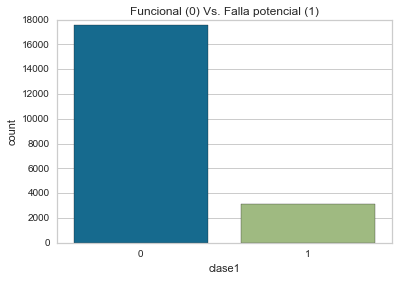

In [5]:
# conteo de observaciones por clase de la base entrenamiento
sns.countplot(label_train)
plt.title('Funcional (0) Vs. Falla potencial (1)')

In [6]:
# sobremuestreo de minorías sintéticas (SMOTE)

data_traino, label_traino = SMOTE().fit_resample(data_train, label_train)
print(sorted(Counter(label_traino).items()))

[(0, 17531), (1, 17531)]


In [7]:
label_train=pd.Series(label_traino)

Text(0.5, 1.0, 'Funcional (0) Vs. Falla potencial (1)')

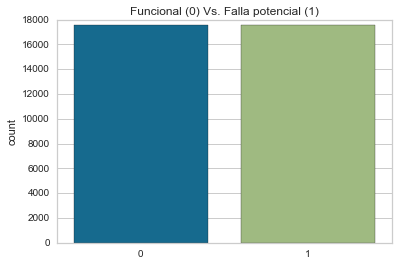

In [8]:
# grafica de base de entrenamiento equilibrada
sns.countplot(label_train)
plt.title('Funcional (0) Vs. Falla potencial (1)')

In [9]:
data_train= pd.DataFrame(data_traino, columns=data_train.columns)

In [10]:
print("numero de dimensiones =", data_train.ndim)
print("tamaño de la tabla =", data_train.shape)
print("total datos =", data_train.size)

numero de dimensiones = 2
tamaño de la tabla = (35062, 25)
total datos = 876550


In [11]:
print("numero de dimensiones =", label_train.ndim)
print("tamaño de la tabla =", label_train.shape)
print("total datos =", label_train.size)

numero de dimensiones = 1
tamaño de la tabla = (35062,)
total datos = 35062


In [12]:
data_train.head()

,ciclo,set1,set2,set3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1.0,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,...,521.66,2388.02,8138.62,8.4195,0.03,392.0,2388.0,100.0,39.06,23.4190
1,2.0,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,...,522.28,2388.07,8131.49,8.4318,0.03,392.0,2388.0,100.0,39.00,23.4236
2,3.0,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,...,522.42,2388.03,8133.23,8.4178,0.03,390.0,2388.0,100.0,38.95,23.3442
3,4.0,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,...,522.86,2388.08,8133.83,8.3682,0.03,392.0,2388.0,100.0,38.88,23.3739
4,5.0,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,...,522.19,2388.04,8133.80,8.4294,0.03,393.0,2388.0,100.0,38.90,23.4044


## Modelos de clasificacion binaria balanceo con sobremuestreo de minorías sintéticas (SMOTE), incluyendo variable ciclo

## Gradient Boosting Classifier hiperparametros por defecto

In [29]:
modelo1=GradientBoostingClassifier(random_state=0)
modelo1.fit(data_train, label_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)



MATRIZ DE CONFUSION




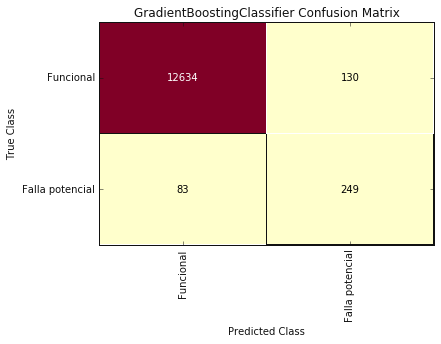



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9837354917532071
ROC AUC: 0.8699075524913821
------------------------------------------------------------
Precisión por clase: [0.9934733  0.65699208]
Sensibilidad - Recall por clase: [0.9898151 0.75     ]
F1 por clase: [0.99164083 0.70042194]
------------------------------------------------------------
F1 Macro: 0.846031385675469
F1 Micro: 0.9837354917532071
F1 Weighted: 0.9842580668832559
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.869907552491382
Sensibilidad - Recall Micro: 0.9837354917532071
Sensibilidad - Recall Weighted: 0.9837354917532071
------------------------------------------------------------
Precisión Macro: 0.8252326939423948
Precisión Micro: 0.9837354917532071
Precisión Weighted: 0.9849430831776046
------------------------------------------------------------
Verdaderos positivos - True Positives: 249
Verdaderos negativos - True Negatives: 12634
Falsos positivos -

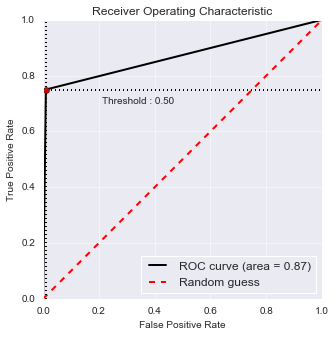

In [30]:
label_pred1 = modelo1.predict(data_test)
# métricas de desempeño - evaluación del modelo
model_evaluation(data_train, label_train, data_test, label_test, modelo1, label_pred1)

## Stratified k-fold cross-validation

Evaluaremos el modelo utilizando validación cruzada estratificada repetida de k veces, con 10 repeticiones y 10 pliegues. Informaremos la desviación media y estándar de la precisión del modelo en todas las repeticiones y pliegues

In [43]:
# evaluar 

model = GradientBoostingClassifier()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
n_scores = cross_val_score(model, data_train, label_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.968 (0.003)


El resultado es una exactitud media de 0.976 con una desviacion estandar de 0.004

## Ajuste de hiperparametros
tomado de https://machinelearningmastery.com/gradient-boosting-machine-ensemble-in-python/

### Explorar el numero de arboles 

In [44]:
# funcion para evaluar lista de modelos
def get_models():
    models = dict()
    models['10'] = GradientBoostingClassifier(n_estimators=10)
    models['50'] = GradientBoostingClassifier(n_estimators=50)
    models['100'] = GradientBoostingClassifier(n_estimators=100)
    models['500'] = GradientBoostingClassifier(n_estimators=500)
    models['1000'] = GradientBoostingClassifier(n_estimators=1000)
    return models

# funcion para evaluar modelo usando CV
def evaluate_model(model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
    scores = cross_val_score(model, data_train, label_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

>10 0.949 (0.004)
>50 0.961 (0.003)
>100 0.968 (0.003)
>500 0.978 (0.002)
>1000 0.979 (0.002)


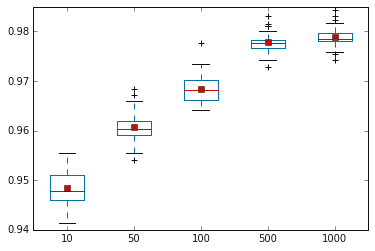

In [45]:
# modelos a evaluar
models = get_models()
# evaluar modelos y guardar resultados
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# graficar el desempeño del modelo para comparacion 
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

se observa que la exactitud aumenta y se mantiene estable después de unos 500 árboles


### Ajustar el numero de muestras (subsample)

In [46]:
def get_models():
    models = dict()
    for i in arange(0.1, 1.1, 0.1):
        key = '%.1f' % i
        models[key] = GradientBoostingClassifier(subsample=i, n_estimators=500)
    return models
 
# evaluar usando cross-validation
def evaluate_model(model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
    scores = cross_val_score(model, data_train, label_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores
 

>0.1 0.970 (0.004)
>0.2 0.975 (0.002)
>0.3 0.977 (0.002)
>0.4 0.977 (0.002)
>0.5 0.977 (0.002)
>0.6 0.978 (0.002)
>0.7 0.978 (0.002)
>0.8 0.978 (0.002)
>0.9 0.978 (0.002)
>1.0 0.978 (0.002)


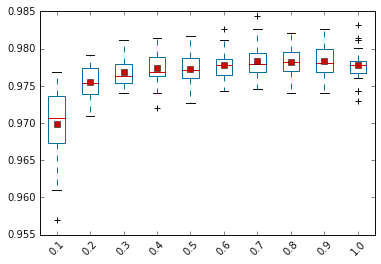

In [47]:
# modelos a evaluar
results, names = list(), list()
models = get_models()
# evaluar modelos y guardar resultados
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# grafico de cajas y bigotes 
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.xticks(rotation=45)
pyplot.show()


los resultados sugieren que un valor entre 0.8 y 0.9

## Ajustar la cantidad de caracteristicas (max_features)

In [48]:
def get_models():
    models = dict()
    for i in range(1,21):
        models[str(i)] = GradientBoostingClassifier(max_features=i)
    return models

# evaluar usando cross-validation
def evaluate_model(model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
    scores = cross_val_score(model, data_train, label_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores


>1 0.960 (0.004)
>2 0.962 (0.004)
>3 0.963 (0.003)
>4 0.964 (0.003)
>5 0.965 (0.003)
>6 0.966 (0.003)
>7 0.966 (0.003)
>8 0.967 (0.003)
>9 0.967 (0.003)
>10 0.967 (0.003)
>11 0.967 (0.003)
>12 0.967 (0.003)
>13 0.967 (0.003)
>14 0.968 (0.003)
>15 0.968 (0.003)
>16 0.968 (0.003)
>17 0.968 (0.003)
>18 0.968 (0.003)
>19 0.968 (0.003)
>20 0.968 (0.003)


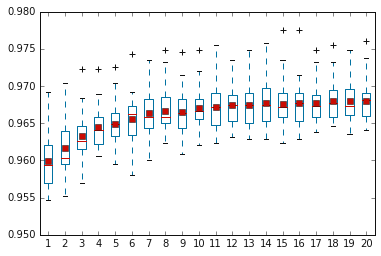

In [49]:
# modelos a evaluar
models = get_models()
# evaluar modelos y guardar resultados
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# graficar el desempeño del modelo para comparacion 
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

## Ajustar la tasa de aprendizaje (Learning Rate)

In [52]:
# lista de modelos a evaluar
def get_models():
    models = dict()
    for i in [0.0001, 0.001, 0.01, 0.1, 1.0]:
        key = '%.4f' % i
        models[key] = GradientBoostingClassifier(learning_rate=i)
    return models

# evaluar usando cross-validation
def evaluate_model(model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
    scores = cross_val_score(model, data_train, label_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores


>0.0001 0.937 (0.004)
>0.0010 0.941 (0.004)
>0.0100 0.949 (0.003)
>0.1000 0.968 (0.003)
>1.0000 0.973 (0.003)


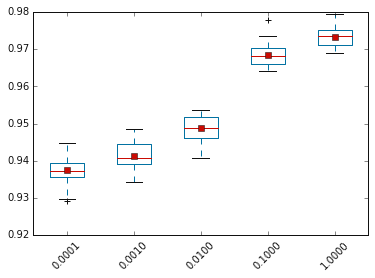

In [53]:
# modelos a evaluar
results, names = list(), list()
models = get_models()
# evaluar modelos y guardar resultados
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# grafico de cajas y bigotes 
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.xticks(rotation=45)
pyplot.show()

## Ajustar la profundidad del árbol (Tree Depth)

In [50]:
# lista de modelos a evaluar
def get_models():
    models = dict()
    for i in range(1,11):
        models[str(i)] = GradientBoostingClassifier(max_depth=i)
    return models

# evaluar usando cross-validation
def evaluate_model(model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
    scores = cross_val_score(model, data_train, label_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores


>1 0.954 (0.004)
>2 0.963 (0.003)
>3 0.968 (0.003)
>4 0.973 (0.003)
>5 0.976 (0.002)
>6 0.977 (0.002)
>7 0.978 (0.002)
>8 0.979 (0.003)
>9 0.980 (0.002)
>10 0.980 (0.002)


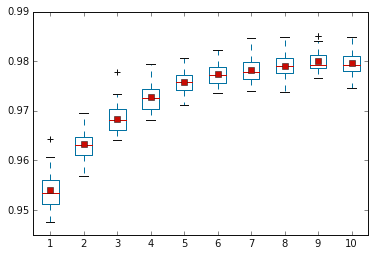

In [51]:
# modelos a evaluar
models = get_models()
# evaluar modelos y guardar resultados
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# graficar el desempeño del modelo para comparacion 
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

Se observa que la exactitud mejora aumentando la profundidad del árbol hasta alcanzar un valor estable entre 9 y 10

## Grid Search with Cross Validation

In [66]:

model = GradientBoostingClassifier(random_state=0)
parameters= {'n_estimators': [500, 1000],
            'subsample': [0.9, 1],
            'learning_rate': [0.1],
            'max_depth': [ 8, 9, 10]            
            }                                       

acc_scorer=make_scorer(fbeta_score, beta=1)

grid = GridSearchCV(estimator = model, param_grid=parameters, cv=3, verbose=2, scoring=acc_scorer, n_jobs = -1)

%time grid.fit(data_train, label_train)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  36 | elapsed:  5.8min remaining:   43.6s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  6.0min finished


Wall time: 7min 18s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presort=

In [67]:
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_index_)

{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1000, 'subsample': 0.9}
0.9703314243109219
10


In [68]:
modelo2a= grid.best_estimator_
modelo2a.fit(data_train, label_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=10,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=0.9, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [69]:
label_pred2a = modelo2a.predict(data_test)

In [70]:
# para evaluar cuales caracteristicas tiene mayor peso en el modelo
fi=modelo2a.feature_importances_
fi

array([0.01812048, 0.00500256, 0.00562849, 0.        , 0.        ,
       0.01039877, 0.00844785, 0.02144682, 0.        , 0.        ,
       0.01726512, 0.00702398, 0.06413605, 0.        , 0.69803145,
       0.03191645, 0.00858136, 0.01412219, 0.0149899 , 0.        ,
       0.05363273, 0.        , 0.        , 0.00915741, 0.01209838])



MATRIZ DE CONFUSION




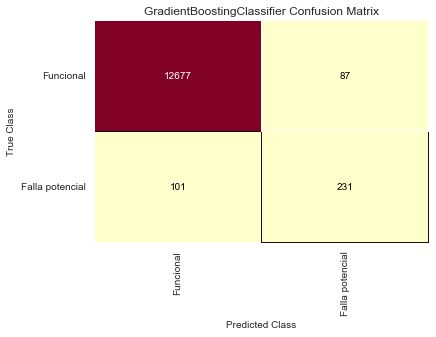



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.98564447159438
ROC AUC: 0.8444835437016005
------------------------------------------------------------
Precisión por clase: [0.99209579 0.72641509]
Sensibilidad - Recall por clase: [0.99318395 0.69578313]
F1 por clase: [0.99263957 0.71076923]
------------------------------------------------------------
F1 Macro: 0.8517044024020768
F1 Micro: 0.98564447159438
F1 Weighted: 0.9854938078495068
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.8444835437016005
Sensibilidad - Recall Micro: 0.98564447159438
Sensibilidad - Recall Weighted: 0.98564447159438
------------------------------------------------------------
Precisión Macro: 0.8592554419890318
Precisión Micro: 0.98564447159438
Precisión Weighted: 0.985360451303132
------------------------------------------------------------
Verdaderos positivos - True Positives: 231
Verdaderos negativos - True Negatives: 12677
Falsos positivos - False 

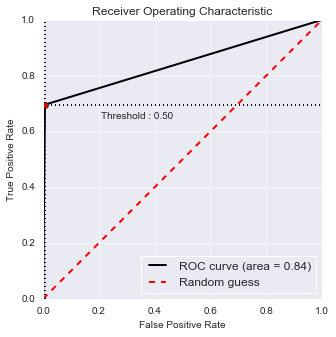

In [71]:
# métricas de desempeño - evaluación del modelo
model_evaluation(data_train, label_train, data_test, label_test, modelo2a, label_pred2a)

# Ajuste avanzado modelo de clasificacion binaria XGBoost

Codigos Tomados del libro XGBoost With Python, Jason Brownlee, 2020.

## XGBoost Model hiperparametros por defecto

In [41]:
model = XGBClassifier()
model.fit(data_train, label_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)



MATRIZ DE CONFUSION




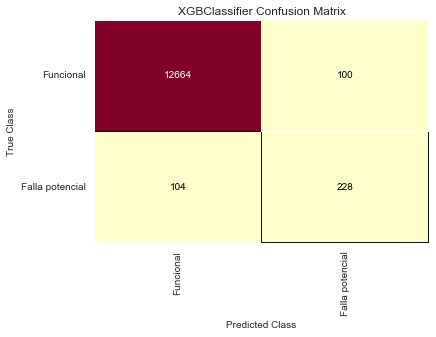



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9844227244960293
ROC AUC: 0.8394562266615821
------------------------------------------------------------
Precisión por clase: [0.99185464 0.69512195]
Sensibilidad - Recall por clase: [0.99216547 0.68674699]
F1 por clase: [0.99201003 0.69090909]
------------------------------------------------------------
F1 Macro: 0.8414595587711677
F1 Micro: 0.9844227244960293
F1 Weighted: 0.9843767408467129
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.8394562266615821
Sensibilidad - Recall Micro: 0.9844227244960293
Sensibilidad - Recall Weighted: 0.9844227244960293
------------------------------------------------------------
Precisión Macro: 0.8434882939054954
Precisión Micro: 0.9844227244960293
Precisión Weighted: 0.9843320914216945
------------------------------------------------------------
Verdaderos positivos - True Positives: 228
Verdaderos negativos - True Negatives: 12664
Falsos positiv

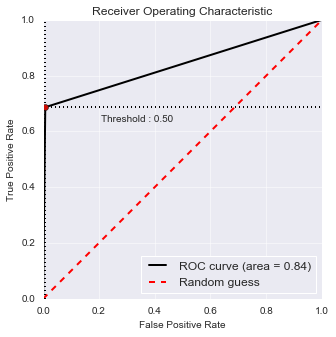

In [42]:
# prediccion con el modelo
label_preda = model.predict(data_test)
model_evaluation(data_train, label_train, data_test, label_test, model, label_preda)

### Evaluar modelo con k-Fold Cross-Validation

In [43]:
model = XGBClassifier()
# numero de pliegues
kfold = KFold(n_splits=3)
n_scores = cross_val_score(model, data_train, label_train, scoring='f1_macro', cv=kfold, n_jobs=-1, error_score='raise')
# report performance
print('F1 score: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


F1 score: 0.793 (0.209)


In [44]:
# evaluar exactitud
model = XGBClassifier()
kfold = KFold(n_splits=3)
results = cross_val_score(model, data_train, label_train, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 97.09% (1.65%)


### Gradient Boosting With XGBoost Stratified k-fold cross-validation

In [45]:
model = XGBClassifier()

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, data_train, label_train, scoring='f1_macro', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('F1 score: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

F1 score: 0.979 (0.001)


### Feature Importance

In [46]:
model = XGBClassifier()
model.fit(data_train, label_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

[0.01306124 0.00402846 0.01367361 0.         0.         0.00922576
 0.00531329 0.04611538 0.         0.         0.02482356 0.01122314
 0.04382599 0.         0.6547195  0.03467204 0.01447377 0.01394267
 0.01293146 0.         0.07849144 0.         0.         0.01009172
 0.0093871 ]


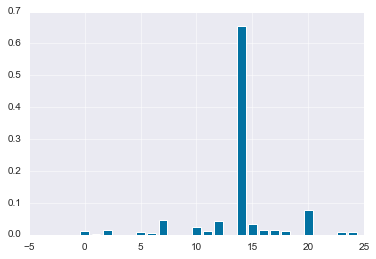

In [47]:
# feature importance
print(model.feature_importances_)
# plot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

### monitor training performance

In [48]:
model = XGBClassifier()
eval_set = [(data_test, label_test)]
model.fit(data_train, label_train, eval_metric="error", eval_set=eval_set, verbose=True)
# make predictions for test data
predictions = model.predict(data_test)
# evaluate predictions
accuracy = accuracy_score(label_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
f1=metrics.f1_score(label_test, predictions, average='macro')
print("F1_score macro: %.2f%%" % (f1 * 100.0))

[0]	validation_0-error:0.02695
[1]	validation_0-error:0.02161
[2]	validation_0-error:0.02115
[3]	validation_0-error:0.02016
[4]	validation_0-error:0.02023
[5]	validation_0-error:0.01909
[6]	validation_0-error:0.01924
[7]	validation_0-error:0.01810
[8]	validation_0-error:0.01772
[9]	validation_0-error:0.01749
[10]	validation_0-error:0.01726
[11]	validation_0-error:0.01718
[12]	validation_0-error:0.01657
[13]	validation_0-error:0.01627
[14]	validation_0-error:0.01657
[15]	validation_0-error:0.01627
[16]	validation_0-error:0.01672
[17]	validation_0-error:0.01649
[18]	validation_0-error:0.01634
[19]	validation_0-error:0.01657
[20]	validation_0-error:0.01619
[21]	validation_0-error:0.01558
[22]	validation_0-error:0.01604
[23]	validation_0-error:0.01596
[24]	validation_0-error:0.01604
[25]	validation_0-error:0.01565
[26]	validation_0-error:0.01558
[27]	validation_0-error:0.01558
[28]	validation_0-error:0.01535
[29]	validation_0-error:0.01527
[30]	validation_0-error:0.01550
[31]	validation_0-

### plot learning curve

[0]	validation_0-error:0.04335	validation_0-logloss:0.47227	validation_1-error:0.02695	validation_1-logloss:0.45457
[1]	validation_0-error:0.03728	validation_0-logloss:0.34796	validation_1-error:0.02161	validation_1-logloss:0.32206
[2]	validation_0-error:0.03445	validation_0-logloss:0.26748	validation_1-error:0.02115	validation_1-logloss:0.23791
[3]	validation_0-error:0.03300	validation_0-logloss:0.21332	validation_1-error:0.02016	validation_1-logloss:0.18140
[4]	validation_0-error:0.03194	validation_0-logloss:0.17585	validation_1-error:0.02023	validation_1-logloss:0.14275
[5]	validation_0-error:0.03012	validation_0-logloss:0.14694	validation_1-error:0.01909	validation_1-logloss:0.11468
[6]	validation_0-error:0.02926	validation_0-logloss:0.12647	validation_1-error:0.01924	validation_1-logloss:0.09498
[7]	validation_0-error:0.02752	validation_0-logloss:0.11034	validation_1-error:0.01810	validation_1-logloss:0.08019
[8]	validation_0-error:0.02612	validation_0-logloss:0.09820	validation_1

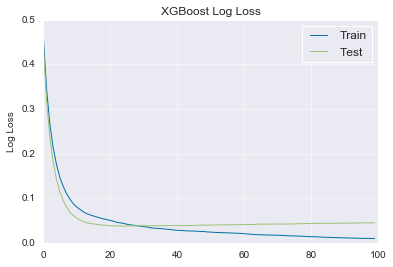

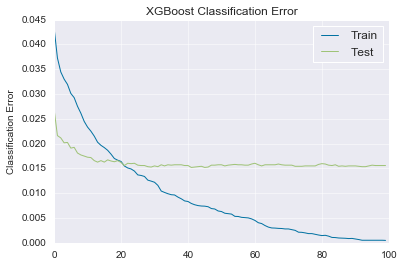

In [49]:
# fit model on training data
model = XGBClassifier()
eval_set = [(data_train, label_train), (data_test, label_test)]
model.fit(data_train, label_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)
# make predictions for test data
predictions = model.predict(data_test)
# evaluate predictions
accuracy = accuracy_score(label_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

### Early Stopping to Avoid Overfitting

In [62]:
model = XGBClassifier()
eval_set = [(data_test, label_test)]
model.fit(data_train, label_train, early_stopping_rounds=10, eval_metric="error", eval_set=eval_set, verbose=True)
# make predictions for test data
predictions = model.predict(data_test)

[0]	validation_0-error:0.02695
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.02161
[2]	validation_0-error:0.02115
[3]	validation_0-error:0.02016
[4]	validation_0-error:0.02023
[5]	validation_0-error:0.01909
[6]	validation_0-error:0.01924
[7]	validation_0-error:0.01810
[8]	validation_0-error:0.01772
[9]	validation_0-error:0.01749
[10]	validation_0-error:0.01726
[11]	validation_0-error:0.01718
[12]	validation_0-error:0.01657
[13]	validation_0-error:0.01627
[14]	validation_0-error:0.01657
[15]	validation_0-error:0.01627
[16]	validation_0-error:0.01672
[17]	validation_0-error:0.01649
[18]	validation_0-error:0.01634
[19]	validation_0-error:0.01657
[20]	validation_0-error:0.01619
[21]	validation_0-error:0.01558
[22]	validation_0-error:0.01604
[23]	validation_0-error:0.01596
[24]	validation_0-error:0.01604
[25]	validation_0-error:0.01565
[26]	validation_0-error:0.01558
[27]	validation_0-error:0.01558
[28]	validation_0-error:0.01535
[29]	validation_

In [63]:
# evaluate predictions
accuracy = accuracy_score(label_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 98.47%


In [64]:
f1=metrics.f1_score(label_test, predictions, average='macro')
print("F1_score macro: %.2f%%" % (f1 * 100.0))

F1_score macro: 85.03%


[0]	validation_0-error:0.04335	validation_0-logloss:0.47227	validation_1-error:0.02695	validation_1-logloss:0.45457
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-error:0.03728	validation_0-logloss:0.34796	validation_1-error:0.02161	validation_1-logloss:0.32206
[2]	validation_0-error:0.03445	validation_0-logloss:0.26748	validation_1-error:0.02115	validation_1-logloss:0.23791
[3]	validation_0-error:0.03300	validation_0-logloss:0.21332	validation_1-error:0.02016	validation_1-logloss:0.18140
[4]	validation_0-error:0.03194	validation_0-logloss:0.17585	validation_1-error:0.02023	validation_1-logloss:0.14275
[5]	validation_0-error:0.03012	validation_0-logloss:0.14694	validation_1-error:0.01909	validation_1-logloss:0.11468
[6]	validation_0-error:0.02926	validation_0-logloss:0.12647	validation_1-error:0.01924	validation_1-logloss:0.09498
[7]	validation_0-error:

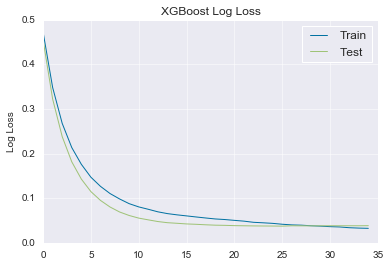

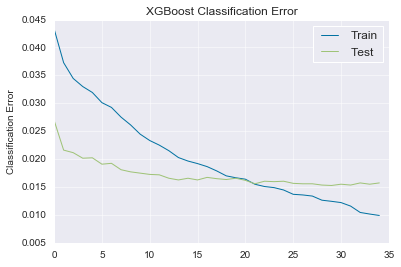

In [65]:
# fit model on training data
model = XGBClassifier()
eval_set = [(data_train, label_train), (data_test, label_test)]
model.fit(data_train, label_train,early_stopping_rounds=10, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)
# make predictions for test data
predictions = model.predict(data_test)
# evaluate predictions
accuracy = accuracy_score(label_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

## Eficient multi-core parallel processing.
Ajustar el numero de nucleos de CPU para mejorar tiempo de entrenamiento

1 7.040175914764404
4 2.2290375232696533
7 1.985692024230957
10 1.6854920387268066


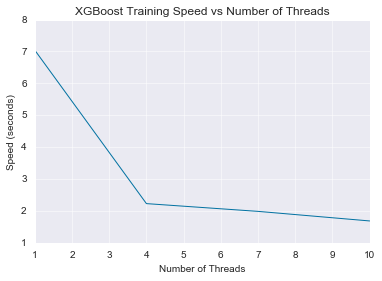

In [66]:
# evaluate the effect of the number of threads
results = []
num_threads = [1, 4, 7, 10]
for n in num_threads:
	start = time()
	model = XGBClassifier(nthread=n)
	model.fit(data_train, label_train)
	elapsed = time() - start
	print(n, elapsed)
	results.append(elapsed)
# plot results
pyplot.plot(num_threads, results)
pyplot.ylabel('Speed (seconds)')
pyplot.xlabel('Number of Threads')
pyplot.title('XGBoost Training Speed vs Number of Threads')
pyplot.show()

## Ajuste de hiperparametros XGBoost Extreme Gradient Boosting Algorithm

### Explorar el numero de arboles 

In [69]:
# funcion para evaluar lista de modelos
def get_models():
    models = dict()
    models['100'] = XGBClassifier(nthread=-1, n_estimators=100)
    models['500'] = XGBClassifier(nthread=-1, n_estimators=500)
    models['1000'] = XGBClassifier(nthread=-1, n_estimators=1000)
    models['2000'] = XGBClassifier(nthread=-1, n_estimators=2000)
    models['3000'] = XGBClassifier(nthread=-1, n_estimators=3000)
    return models

# funcion para evaluar modelo usando CV
def evaluate_model(model):
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)
    scores = cross_val_score(model, data_train, label_train, scoring='f1_macro', cv=kfold, n_jobs=-1, error_score='raise')
    return scores

>100 0.979 (0.000214)
>500 0.981 (0.001015)
>1000 0.981 (0.000690)
>2000 0.980 (0.000668)
>3000 0.980 (0.000445)


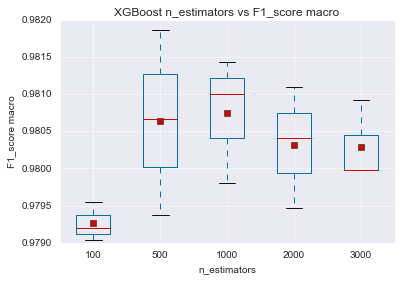

In [70]:
# modelos a evaluar
models = get_models()
# evaluar modelos y guardar resultados
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.6f)' % (name, mean(scores), std(scores)))
# graficar el desempeño del modelo para comparacion 
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.title("XGBoost n_estimators vs F1_score macro")
pyplot.xlabel('n_estimators')
pyplot.ylabel('F1_score macro')
pyplot.show()

## Ajustar la profundidad del árbol (Tree Depth)

In [71]:
# lista de modelos a evaluar
def get_models():
    models = dict()
    for i in [4, 6, 8, 10, 12]:
        models[str(i)] = XGBClassifier(nthread=-1, max_depth=i)
    return models

# evaluar usando cross-validation
def evaluate_model(model):
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)
    scores = cross_val_score(model, data_train, label_train, scoring='f1_macro', cv=kfold, n_jobs=-1, error_score='raise')
    return scores


>4 0.978 (0.000176)
>6 0.979 (0.000214)
>8 0.980 (0.000924)
>10 0.980 (0.000770)
>12 0.980 (0.000424)


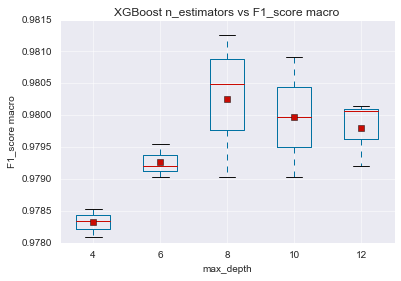

In [72]:
# modelos a evaluar
models = get_models()
# evaluar modelos y guardar resultados
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.6f)' % (name, mean(scores), std(scores)))
# graficar el desempeño del modelo para comparacion 
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.title("XGBoost n_estimators vs F1_score macro")
pyplot.xlabel('max_depth')
pyplot.ylabel('F1_score macro')
pyplot.show()

##  Ajustar la tasa de aprendizaje (Learning Rate)

Podemos utilizar la capacidad de búsqueda de la cuadrícula en scikit-learn para evaluar el efecto sobre la pérdida logarítmica de
entrenar un modelo de aumento de gradiente con diferentes valores de tasa de aprendizaje. Retendremos el número
de árboles constantes en el valor predeterminado de 100.

In [13]:
# get a list of models to evaluate
def get_models():
    models = dict()
    for i in [0.01, 0.05, 0.1, 0.3, 0.5, 1.0]:
        key = '%.4f' % i
        models[key] = XGBClassifier(nthread=-1, learning_rate=i)
    return models

# evaluar usando cross-validation
def evaluate_model(model):
    kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)
    scores = cross_val_score(model, data_train, label_train, scoring='f1_macro', cv=kfold, n_jobs=-1, error_score='raise')
    return scores


>0.0100 0.959 (0.000623)
>0.0500 0.970 (0.000674)
>0.1000 0.976 (0.000536)
>0.3000 0.979 (0.000214)
>0.5000 0.979 (0.000821)
>1.0000 0.977 (0.000879)


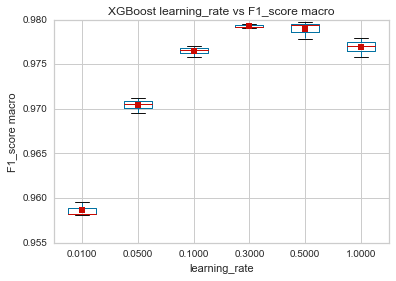

In [14]:
# modelos a evaluar
models = get_models()
# evaluar modelos y guardar resultados
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.6f)' % (name, mean(scores), std(scores)))
# graficar el desempeño del modelo para comparacion 
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.title("XGBoost learning_rate vs F1_score macro")
pyplot.xlabel('learning_rate')
pyplot.ylabel('F1_score macro')
pyplot.show()

Se observa que el F1 aumenta hasta hasta la tasa de aprendizaje de 0.3 y empieza a disminuir. dado que hay un equilibrio entre la tasa de aprendizaje y el numero de arboles se explorarana en conjunto para analizar el rendimiento del modelo.

## Ajuste del muestreo de filas 

### Ajustar el numero de muestras (subsample)

In [13]:
def get_models():
    models = dict()
    for i in arange(0.1, 1.1, 0.1):
        key = '%.1f' % i
        models[key] = XGBClassifier(nthread=-1, subsample=i)
    return models
 
# evaluar usando cross-validation
def evaluate_model(model):
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=0)
    scores = cross_val_score(model, data_train, label_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores
 

>0.1 0.968 (0.002)
>0.2 0.974 (0.001)
>0.3 0.976 (0.001)
>0.4 0.978 (0.001)
>0.5 0.978 (0.001)
>0.6 0.979 (0.002)
>0.7 0.979 (0.001)
>0.8 0.979 (0.001)
>0.9 0.980 (0.001)
>1.0 0.980 (0.002)


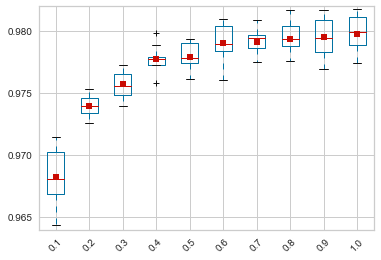

In [14]:
# modelos a evaluar
results, names = list(), list()
models = get_models()
# evaluar modelos y guardar resultados
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# grafico de cajas y bigotes 
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.xticks(rotation=45)
pyplot.show()


## Evaluacion de desempeño del modelo ajustado y entrenado

## XGBoost Classifier

In [26]:
modelo13=XGBClassifier(nthread=-1, max_depth=10, n_estimators=2000, learning_rate=0.001, subsample=0.9)
modelo13.fit(data_train, label_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.001, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=2000, n_jobs=-1, nthread=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)



MATRIZ DE CONFUSION




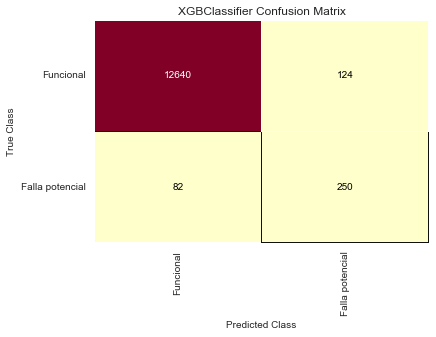



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9842700061087355
ROC AUC: 0.8716486126266269
------------------------------------------------------------
Precisión por clase: [0.99355447 0.6684492 ]
Sensibilidad - Recall por clase: [0.99028518 0.75301205]
F1 por clase: [0.99191713 0.7082153 ]
------------------------------------------------------------
F1 Macro: 0.8500662142121465
F1 Micro: 0.9842700061087355
F1 Weighted: 0.9847249342168594
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.8716486126266269
Sensibilidad - Recall Micro: 0.9842700061087355
Sensibilidad - Recall Weighted: 0.9842700061087355
------------------------------------------------------------
Precisión Macro: 0.8310018352140844
Precisión Micro: 0.9842700061087355
Precisión Weighted: 0.9853126467270664
------------------------------------------------------------
Verdaderos positivos - True Positives: 250
Verdaderos negativos - True Negatives: 12640
Falsos positiv

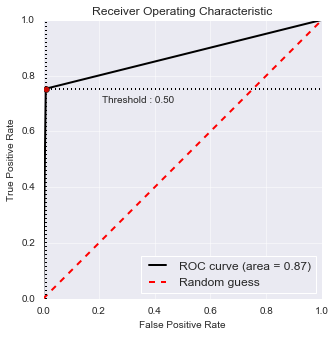

In [27]:
# prediccion con el modelo

label_pred13 = modelo13.predict(data_test)

model_evaluation(data_train, label_train, data_test, label_test, modelo13, label_pred13)

## XGBoost Classifier disminuyendo la profundidad del arbol

In [39]:
modelo14=XGBClassifier(nthread=-1, max_depth=8, n_estimators=2000, learning_rate=0.001, subsample=0.9)
modelo14.fit(data_train, label_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.001, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=2000, n_jobs=-1, nthread=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)



MATRIZ DE CONFUSION




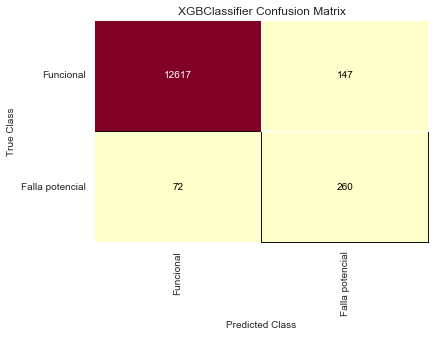



MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9832773365913255
ROC AUC: 0.8858078821081883
------------------------------------------------------------
Precisión por clase: [0.99432579 0.63882064]
Sensibilidad - Recall por clase: [0.98848323 0.78313253]
F1 por clase: [0.99139591 0.70365359]
------------------------------------------------------------
F1 Macro: 0.847524746053473
F1 Micro: 0.9832773365913255
F1 Weighted: 0.9841012780245486
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.8858078821081883
Sensibilidad - Recall Micro: 0.9832773365913255
Sensibilidad - Recall Weighted: 0.9832773365913255
------------------------------------------------------------
Precisión Macro: 0.8165732164077186
Precisión Micro: 0.9832773365913255
Precisión Weighted: 0.9853132931153071
------------------------------------------------------------
Verdaderos positivos - True Positives: 260
Verdaderos negativos - True Negatives: 12617
Falsos positivo

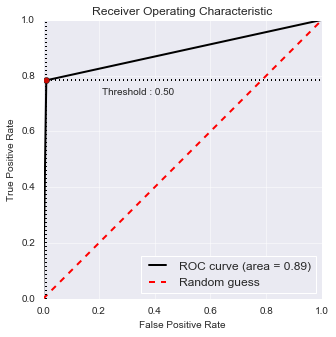

In [40]:
# prediccion con el modelo

label_pred14 = modelo14.predict(data_test)

model_evaluation(data_train, label_train, data_test, label_test, modelo14, label_pred14)

### Plot learning curve

[0]	validation_0-error:0.03425	validation_0-logloss:0.69225	validation_1-error:0.02466	validation_1-logloss:0.69220
[1]	validation_0-error:0.03180	validation_0-logloss:0.69138	validation_1-error:0.02291	validation_1-logloss:0.69127
[2]	validation_0-error:0.03003	validation_0-logloss:0.69050	validation_1-error:0.02169	validation_1-logloss:0.69034
[3]	validation_0-error:0.02932	validation_0-logloss:0.68962	validation_1-error:0.02153	validation_1-logloss:0.68939
[4]	validation_0-error:0.02843	validation_0-logloss:0.68874	validation_1-error:0.02237	validation_1-logloss:0.68846
[5]	validation_0-error:0.02909	validation_0-logloss:0.68786	validation_1-error:0.02161	validation_1-logloss:0.68753
[6]	validation_0-error:0.02883	validation_0-logloss:0.68699	validation_1-error:0.02130	validation_1-logloss:0.68661
[7]	validation_0-error:0.02909	validation_0-logloss:0.68610	validation_1-error:0.02100	validation_1-logloss:0.68568
[8]	validation_0-error:0.02883	validation_0-logloss:0.68523	validation_1

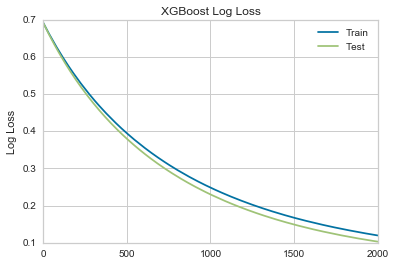

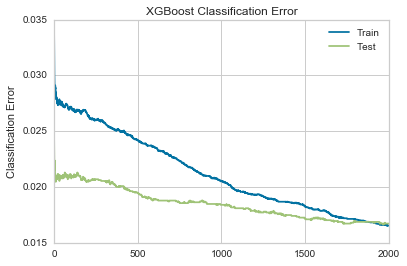

In [15]:
# fit model on training data
model = XGBClassifier(nthread=-1, max_depth=8, n_estimators=2000, learning_rate=0.001, subsample=0.9)
eval_set = [(data_train, label_train), (data_test, label_test)]
model.fit(data_train, label_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)
# make predictions for test data
predictions = model.predict(data_test)
# evaluate predictions
accuracy = accuracy_score(label_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

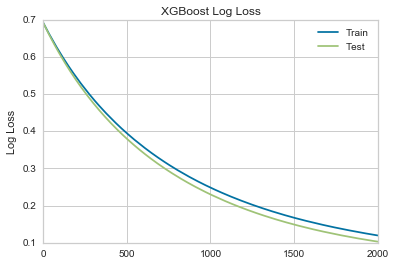

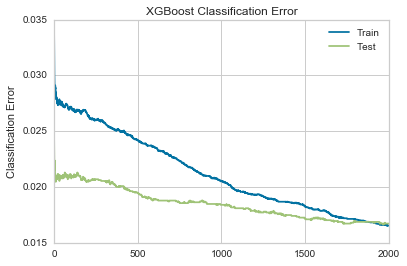

In [17]:
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

El modelo se ajusta adecuademente y con la configuracion de hiperparametros mejora las metricas de desempeño ubicandose como el mejor algoritmo de ML por debajo de la red CNN y LSTM.